<a href="https://colab.research.google.com/github/Guywell/229352-StatisticalLearning/blob/main/Lab09_Neural_Networks(660510772).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Statistical Learning for Data Science 2 (229352)
#### Instructor: Donlapark Ponnoprat

#### [Course website](https://donlapark.pages.dev/229352/)

## Lab #9

In [20]:
%%capture
!git clone https://github.com/donlapark/ds352-labs.git

In [21]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

## Training a neural network in PyTorch

### Chihuahua or Muffin?

<center><img src="https://donlapark.pages.dev/229352/lab09-preview.jpg" width="500"/></center>

### 1. Data preparation

#### Load images, resize them to 128x128, and normalize the pixels to be in 0 - 1 range

In [22]:
transform = transforms.Compose([transforms.Resize((128, 128)),
                                transforms.ToTensor()])  # transform pixels to be in 0 - 1 range

dataset = datasets.ImageFolder(root="ds352-labs/lab09-data/train",
                                         transform=transform) # สร้าง test train folder

#### Split the dataset into training (80%), validation (20%)

# add
### Hyperparameter

1. learning rate
2. Batch size
3. Epoch

In [23]:
train_size = int(0.8 * len(dataset)) # train 80  val 20
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

#### Load the datasets into DataLoader

In [24]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=10,
                          shuffle=True)
val_loader = DataLoader(dataset=val_dataset,
                        batch_size=len(val_dataset),
                        shuffle=False)

#### Do the same for the test images

In [25]:
test_dataset = datasets.ImageFolder(root="ds352-labs/lab09-data/test",
                                    transform=transform)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=len(test_dataset),
                         shuffle=False)

#### Looking at the first minibatch

In [26]:
#add
train_loader

In [27]:
train_batches = iter(train_loader)
X, y = next(train_batches)

print(X.shape)  # (batch_size, channel, height, weight)
print(y.shape)

torch.Size([10, 3, 128, 128])
torch.Size([10])


In [28]:
#add
y

tensor([0, 1, 1, 0, 0, 1, 0, 1, 0, 1])

In [14]:
X[0]

array([[[0.5254902 , 0.44705883, 0.44313726],
        [0.5176471 , 0.4392157 , 0.43529412],
        [0.5137255 , 0.43529412, 0.43137255],
        ...,
        [0.49411765, 0.49019608, 0.50980395],
        [0.5137255 , 0.5058824 , 0.5254902 ],
        [0.5372549 , 0.5294118 , 0.5411765 ]],

       [[0.52156866, 0.44313726, 0.4392157 ],
        [0.5137255 , 0.43529412, 0.43137255],
        [0.50980395, 0.43137255, 0.42745098],
        ...,
        [0.5137255 , 0.5137255 , 0.5254902 ],
        [0.5254902 , 0.5137255 , 0.5294118 ],
        [0.53333336, 0.52156866, 0.5294118 ]],

       [[0.5176471 , 0.4392157 , 0.43137255],
        [0.50980395, 0.43137255, 0.42352942],
        [0.5058824 , 0.42745098, 0.41960785],
        ...,
        [0.53333336, 0.5254902 , 0.53333336],
        [0.5294118 , 0.50980395, 0.52156866],
        [0.52156866, 0.49803922, 0.50980395]],

       ...,

       [[0.5019608 , 0.43137255, 0.17254902],
        [0.5019608 , 0.42745098, 0.1764706 ],
        [0.49803922, 0

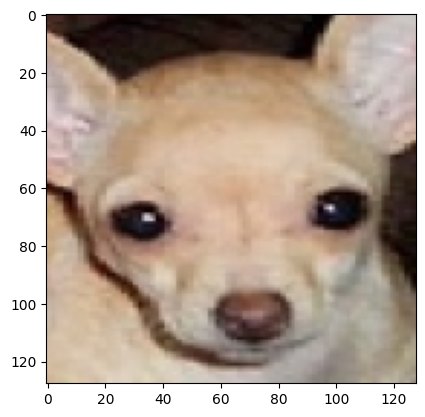

In [29]:
plt.imshow(X[0].numpy().transpose(1 , 2, 0))  # Convert from (C, H, W) to (H, W, C)
#add

#### Visualize the first four images in the batch

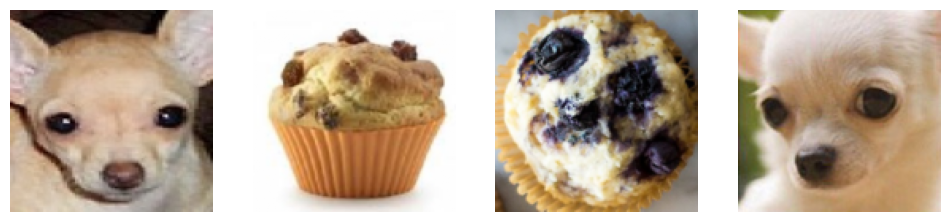

tensor([0, 1, 1, 0])


In [30]:
X = X[:4]  # Select the first 4 images
X = X.numpy().transpose(0, 2, 3, 1)  # Convert from (B, C, H, W) to (B, H, W, C)

# Plot images
fig, axes = plt.subplots(1, 4, figsize=(12, 4))
for i in range(4):
    axes[i].imshow(X[i])
    axes[i].axis('off')
plt.show()

print(y[:4])

### 2. Build a simple logistic regression

<center><img src="https://donlapark.pages.dev/229352/logistic.png" width="300"/></center>

The most important component of the model class is the `__init__` method and the `forward` method.  
  
[Activation functions in PyTorch](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity). The most important ones are [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html), [Sigmoid](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html), [Softmax](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html), [Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html).

In [60]:
#add
class SimpleLogisticRegression(nn.Module):
  def __init__(self):
    super(SimpleLogisticRegression, self).__init__()
    # (B, C, H, W) = (10, 3, 128, 128)
    self.flatten = nn.Flatten()   # (10, 49152)
    self.linear = nn.Linear(3 * 128 * 128)  # input (10,128)
    self.act1 = nn.ReLU()
    self.activation = nn.Sigmoid() # (10, 1)

  def forward(self, x):
    x = self.flatten(x)  # Flatten the input
    x = self.linear(x)
    X = self.act1(x)
    # next layer...
    x = self.activation(x)
    return x

### 3. Initialize training components

#### Initialize the model and loss function

[Loss functions in PyTorch](https://pytorch.org/docs/stable/nn.html#loss-functions). Most important ones are [MSE](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html), [Binary cross, entropy](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html), [Categorical cross entropy](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).

In [35]:
model = SimpleLogisticRegression()
criterion = nn.BCELoss()

#### Manually setting initial weights to zero for demonstration

In [36]:
with torch.no_grad():
  for layer in model.modules():
      if isinstance(layer, nn.Linear):
          layer.weight.zero_()
          layer.bias.zero_()

#### Create two lists to collect training and validation losses

In [37]:
# List to store the loss values for plotting
train_losses = []
val_losses = []

#### Specify the learning rate

In [38]:
learning_rate = 1e-3

### 4. Training the model with gradient descent

#### Convert the dataloader into minibatches

In [39]:
#add
train_batches = iter(train_loader)
X, y = next(train_batches)

In [41]:
#add
x,y = next(train_batches)

#### Make a prediction on the minibatch (Forward pass)

In [44]:
#add
y_hat = model(X)

y_hat = y_hat[:, 0]
y = y.to(torch.float32)

#y_hat = y_hat[:, 0]
#y = y.to(torch.float32)

#### Calculate the loss function

Recall that `criterion()` is our binary cross-entropy loss (`BCELoss`).

In [45]:
# Compute the loss
#add
loss = criterion(y_hat, y)
train_losses.append(loss.item())

In [46]:
train_losses

[0.6931471824645996]

#### Calculate the gradient (Backward pass)

In [51]:
# Backward pass: compute the gradient of the loss w.r.t. model parameters
#add
loss.backward()

In [52]:
#add
for param in model.parameters():
  print(param)

Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.]], requires_grad=True)
Parameter containing:
tensor([0.], requires_grad=True)


In [53]:
for param in model.parameters():
  print(param.grad)

tensor([[-0.0116, -0.0094, -0.0063,  ..., -0.0035, -0.0075, -0.0080]])
tensor([0.])


#### Perform a gradient descent step

Careful! We must not include this step in the gradient calculation, hence the use of `with torch.no_grad()`.

In [54]:
# Manually update the weights using the gradient descent rule
#add
with torch.no_grad():
  for param in model.parameters():
    param -= learning_rate * param.grad

# Zero the gradients after updating
model.zero_grad()

#### Do the same for the validation set

Careful! Anything in the validation step must not be included in the gradient calculation, hence the use of `with torch.no_grad()`.

In [55]:
with torch.no_grad():
  for X, y in val_loader:
    y_hat = model(X)
    y_hat = y_hat[:, 0]
    y = y.to(torch.float32)
    val_loss = criterion(y_hat, y)
    val_losses.append(val_loss.item())

In [56]:
print(train_losses)
print(val_losses)

[0.6931471824645996]
[0.694054901599884]


#### Combine everything together.

Repeat the previous steps for 20 **epochs** and plot the training and validation losses.

In [ ]:
model = SimpleLogisticRegression()
criterion = nn.BCELoss()

with torch.no_grad():
  for layer in model.modules():
      if isinstance(layer, nn.Linear):
          layer.weight.zero_()
          layer.bias.zero_()

train_losses = []
val_losses = []

learning_rate = 1e-4

for epoch in range(20):
  for X, y in train_loader:
    y_hat = model(X)
    y_hat = y_hat[:, 0]
    y = y.to(torch.float32)

    loss = criterion(y_hat, y)
    train_losses.append(loss.item())

    loss.backward()

    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad

    # Zero the gradients after updating
    model.zero_grad()

    with torch.no_grad():
      for X, y in val_loader:
        y_hat = model(X)
        y_hat = y_hat[:, 0]
        y = y.to(torch.float32)
        val_loss = criterion(y_hat, y)
        val_losses.append(val_loss)

  return train_losses, val_losses

model = SimpleLogisticRegression()
train_losses, val_losses = train_model(model, lec-2)


# Plot the training and validation loss
plt.plot(range(1, len(train_losses)+1), train_losses, marker='o', label='Training Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, marker='x', label='Validation Loss')
plt.title('Training and Validation Loss per Batch')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Exercise

In this exercise, we will add more layers to our classification model.

<img src="https://donlapark.pages.dev/229352/lab09-architecture.png" width="450"/>

1. Create a neural network with 3 hidden layers as shown in the picture.

2. Train the model with learning rate = 1e-2, 1e-3, 1e-4, 1e-5, and answer the following questions.
    2.1 What value of learning rate do you **think** is the best? Please explain your reason.
    2.2 What happens to the training losses if your learning rate is too large?
    2.3 What happens to the training losses if your learning rate is too small?

3. After finish training your model. Make the predictions on the test set and compute the accuracy. You may use the provided code below.

4. Use `plt.imshow()` to display at least four images that are incorrectly classified by this model.

In [59]:
# Use this code to calculate test accuracy
with torch.no_grad():
  test_batches = iter(test_loader)
  X, y = next(test_batches)
  y_hat = model(X)
  y_hat = y_hat[:, 0]
  y_hat = (y_hat > 0.5).float()  # the predictions
  ##TODO: compute accuracy


In [ ]:
#1.


In [61]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(3 * 128 * 128, 128)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.linear3 = nn.Linear(64, 32)
        self.relu3 = nn.ReLU()
        self.linear4 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.relu1(x)
        x = self.linear2(x)
        x = self.relu2(x)
        x = self.linear3(x)
        x = self.relu3(x)
        x = self.linear4(x)
        x = self.sigmoid(x)
        return x

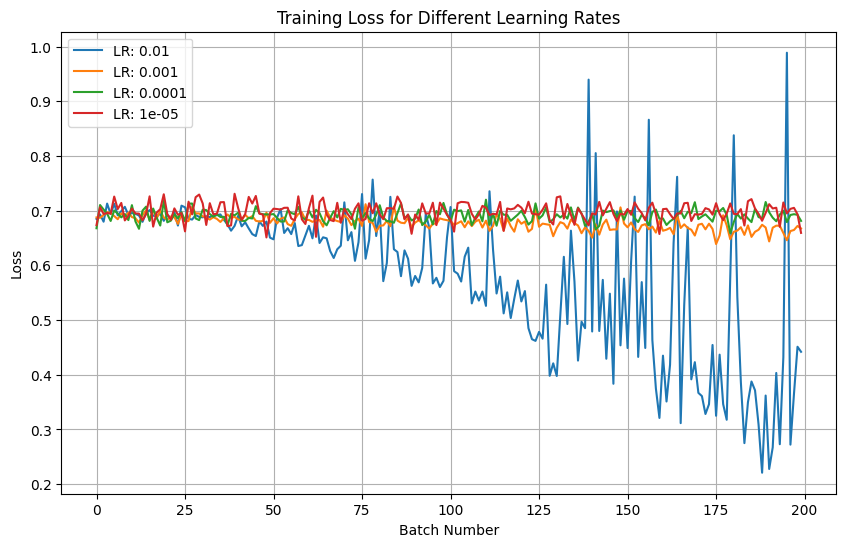

In [62]:
#2.
learning_rates = [1e-2, 1e-3, 1e-4, 1e-5]
epochs = 20

plt.figure(figsize=(10, 6))

for lr in learning_rates:
    model = NeuralNetwork()
    criterion = nn.BCELoss()
    optimizer = optim.SGD(model.parameters(), lr=lr) # Using SGD optimizer

    train_losses = []

    for epoch in range(epochs):
        for X, y in train_loader:
            # Forward pass
            y_hat = model(X)
            y_hat = y_hat[:, 0]
            y = y.to(torch.float32)

            # Compute loss
            loss = criterion(y_hat, y)
            train_losses.append(loss.item())

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    plt.plot(train_losses, label=f'LR: {lr}')

plt.title('Training Loss for Different Learning Rates')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

2.1 1e-3 เพราะ แสดงให้เห็นถึงการลดลงของการสูญเสียในการฝึกอบรมที่มีนัยสำคัญและค่อนข้างคงที่เมื่อเทียบกับอัตราการเรียนรู้ที่อื่นในจำนวนรอบการฝึกอบรมที่กำหนด.

2.2 การสูญเสียในการฝึกอบรมอาจมีการเปลี่ยนแปลงอย่างไม่มีระเบียบและอาจไม่ลดลงอย่างต่อเนื่อง อาจเกิดขึ้นได้เพราะการปรับปรุงที่ใหญ่เกินไปต่อค่าน้ำหนักของโมเดลอาจทำให้กระบวนการเพิ่มประสิทธิภาพพลาดเป้าหมายต่ำสุดของฟังก์ชันการสูญเสีย.

2.3 การสูญเสียในการฝึกจะลดลงอย่างช้า ๆ กระบวนการปรับแต่งจะดำเนินไปทีละน้อย และจะใช้เวลาอีกหลายช่วงในการถึงระดับการสูญเสียที่คล้ายคลึงกับอัตราการเรียนรู้ที่เหมาะสมมากขึ้น.

In [66]:
# 3.
with torch.no_grad():
  test_batches = iter(test_loader)
  X, y = next(test_batches)
  y_hat = model(X)
  y_hat = y_hat[:, 0]
  y_hat = (y_hat > 0.5).float()  # the predictions

  # Compute accuracy
  correct_predictions = (y_hat == y.to(torch.float32)).sum().item()
  total_predictions = y.size(0)
  accuracy = correct_predictions / total_predictions

print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.4333


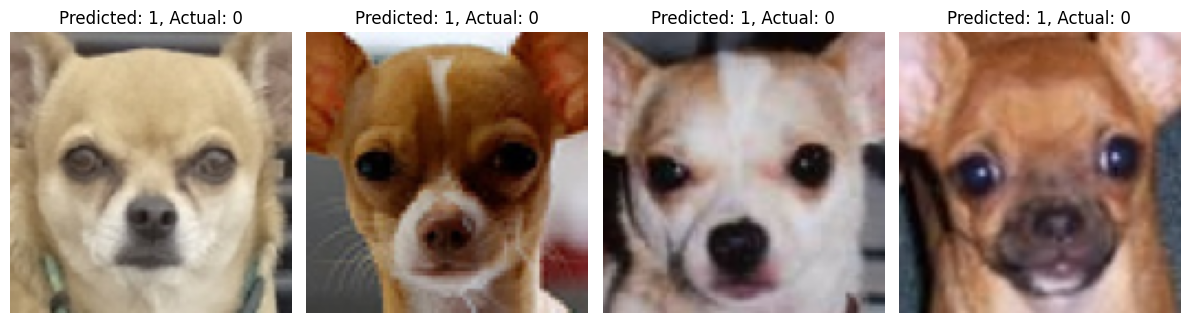

In [67]:
# 4.
incorrect_indices = torch.where(y_hat != y.to(torch.float32))[0]

plt.figure(figsize=(12, 6))
for i in range(min(len(incorrect_indices), 4)):
    idx = incorrect_indices[i]
    image = X[idx].permute(1, 2, 0).numpy() # Convert from (C, H, W) to (H, W, C) and to numpy
    plt.subplot(1, 4, i + 1)
    plt.imshow(image)
    plt.title(f"Predicted: {int(y_hat[idx])}, Actual: {int(y[idx])}")
    plt.axis('off')

plt.tight_layout()
plt.show()